In [1]:
!pip install scikit-image

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from skimage import data, transform, io, exposure
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT, match_template, ORB
from skimage.transform import rescale, resize, downscale_local_mean, estimate_transform,  warp, AffineTransform

import rasterio as rio
from rasterio.crs import CRS

import cv2
from affine import Affine
import numpy as np
import os

Image.MAX_IMAGE_PIXELS = 933120000

In [3]:
map_raster = Image.open(r"D:\FloodChange\BaseRaster\BaseTest.tif")
base_map = np.asarray(map_raster)[:,:,0]

In [4]:
base_map.shape

(17279, 23449)

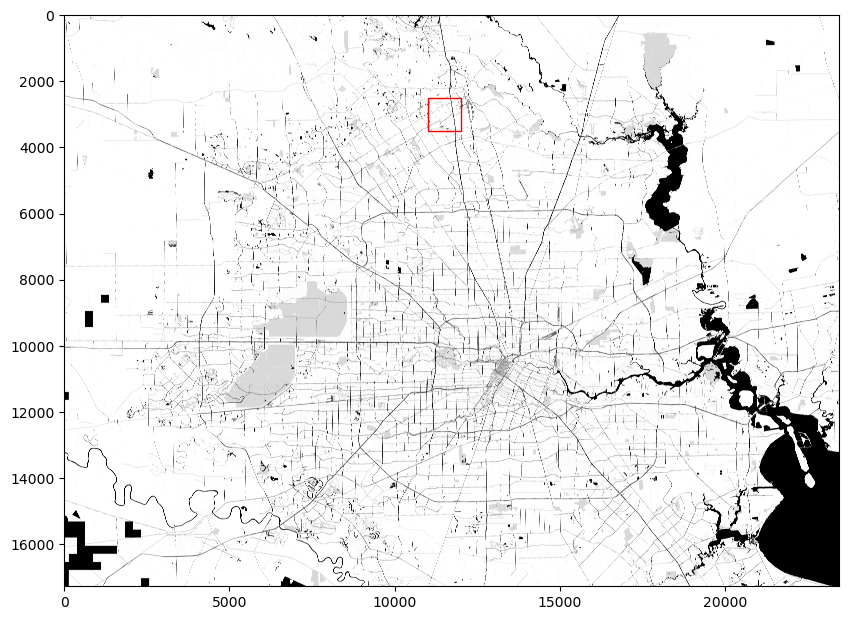

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
# Create a Rectangle patch
rect = patches.Rectangle((11000, 2500), 1000, 1000, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
ax.imshow(base_map, cmap="Greys_r")

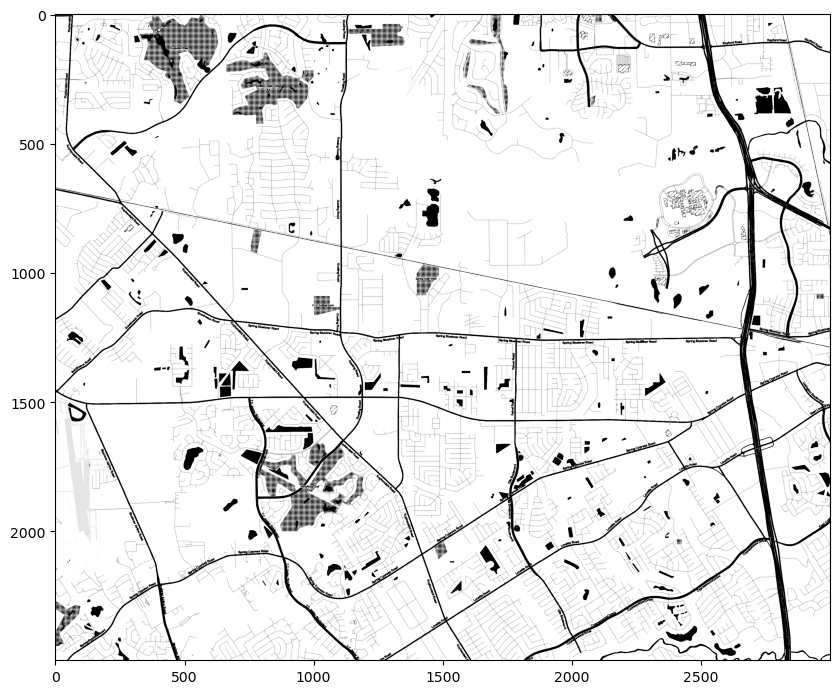

In [152]:
fig, ax = plt.subplots(figsize=(10,10))
base_map_trim = base_map[1000:3500, 9000:12000]
base_map_trim_r = (255 - base_map_trim) 
test = base_map_trim_r / 70 * 255
base_map_trim = 255 - np.where(test > 255, 255, test)
ax.imshow(base_map_trim, cmap="Greys_r")

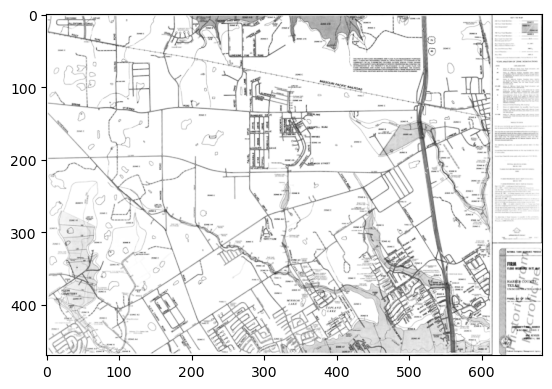

In [7]:
tomatch_map = np.asarray(Image.open(r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\data\4802870065E.png"))
tomatch_resize = resize(tomatch_map, (tomatch_map.shape[0] // 8, tomatch_map.shape[1] // 8)) * 255
# tomatch_resize = np.logical_and(tomatch_resize < 150, tomatch_resize > 100)
plt.imshow(tomatch_resize, cmap="Greys_r")

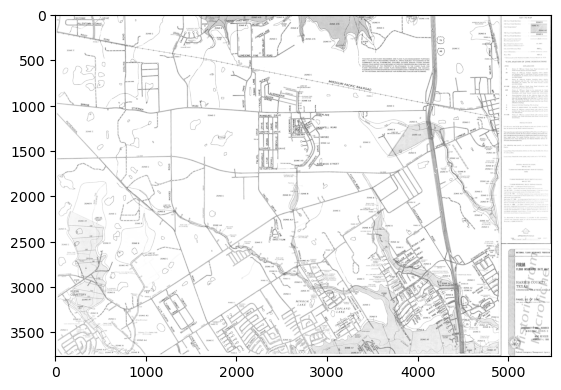

In [8]:
plt.imshow(tomatch_map, cmap="Greys_r")

In [133]:
template_to_match = resize(tomatch_map, (tomatch_map.shape[0] // 10, tomatch_map.shape[1] // 10))
baseraster = resize(base_map, (tomatch_map.shape[0] // 10, tomatch_map.shape[1] // 10))

In [146]:
descriptor_extractor = ORB(n_keypoints=50000)
descriptor_extractor.detect_and_extract(template_to_match)
keypoints_base = descriptor_extractor.keypoints
descriptors_base = descriptor_extractor.descriptors

In [147]:
descriptor_extractor.detect_and_extract(baseraster)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

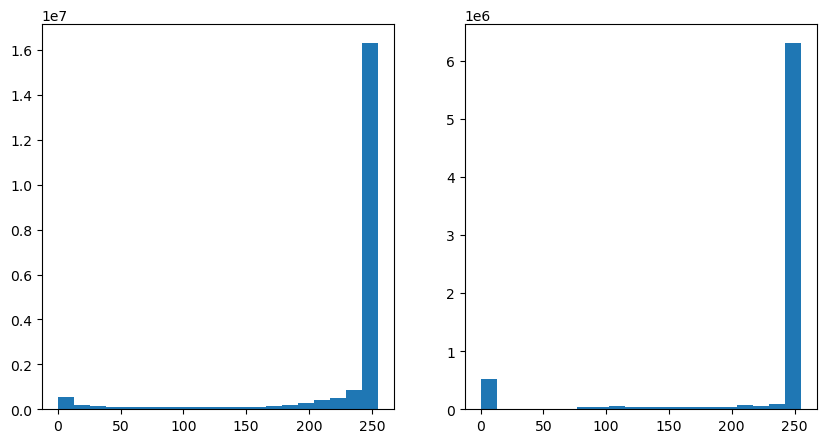

In [153]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
_ = axs[0].hist(tomatch_map.flatten(), bins=20)
_ = axs[1].hist(base_map_trim.flatten(), bins=20)

In [229]:
def pad_for_pyrdown(image, scale_factor):
    h, w = image.shape[:2]
    padded_h = max(int(h / scale_factor), h)
    padded_w = max(int(w / scale_factor), w)
    
    padded_h += padded_h % 2
    padded_w += padded_w % 2
    
    # Round padded dimensions to nearest even integer
    final_h = padded_h - h
    final_w = padded_w - w
    
    padded_image = cv2.copyMakeBorder(image, 0, final_h, 0, final_w,
                                      cv2.BORDER_CONSTANT, value=(0, 0, 0))
    
    return padded_image

# Create the scale-space pyramid
num_scales = 3
scaled_images = []
scaled_images.append(img)
for i in range(1, num_scales):
    scale_factor = 2 ** i
    img_curr = pad_for_pyrdown(scaled_images[-1], scale_factor)
    rows, cols, _ = img_curr.shape
    scaled = cv2.pyrDown(scaled_images[-1])
    scaled_images.append(scaled)

In [ ]:
# Create the ORB object
orb = cv2.ORB_create(nfeatures=1000)

# Detect and describe features for each level of the pyramid
keypoints = []
descriptors = []
for i in range(num_scales):
    kp, des = orb.detectAndCompute(scaled_images[i], None)
    keypoints.append(kp)
    descriptors.append(des)

In [235]:
img1 = cv2.imread(r"D:\FloodChange\BaseRaster\BaseTest.tif")
img2 = cv2.imread(r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\data\4802870065E.png")

In [236]:
# Create the scale-space pyramid for both images
num_scales = 3
scale_factor = 2
scaled_images1 = []
scaled_images2 = []
scaled_images1.append(img1)
scaled_images2.append(img2)
for i in range(1, num_scales):
    scaled1 = cv2.pyrDown(scaled_images1[i-1])
    scaled2 = cv2.pyrDown(scaled_images2[i-1])
    scaled_images1.append(scaled1)
    scaled_images2.append(scaled2)

In [245]:
# Create the ORB object
orb = cv2.ORB_create(nfeatures=1000)

# Detect and describe features for each level of the pyramid for both images
keypoints1 = []
descriptors1 = []
keypoints2 = []
descriptors2 = []
for i in range(num_scales):
    kp1, des1 = orb.detectAndCompute(scaled_images1[i], None)
    kp2, des2 = orb.detectAndCompute(scaled_images2[i], None)
    keypoints1.append(kp1)
    descriptors1.append(des1)
    keypoints2.append(kp2)
    descriptors2.append(des2)

In [246]:
# Create a Brute-Force Matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match the descriptors for each level of the pyramid
matches = []
for i in range(num_scales):
    match = bf.match(descriptors1[i], descriptors2[i])
    matches.append(match)

# Create an array of the matches for each level of the pyramid
match_array = []
for i in range(num_scales):
    print(i)
    matches_i = matches[i]
    matches_i_array = np.zeros((len(matches_i), 4))
    for j, match in enumerate(matches_i):
        matches_i_array[j] = [match.queryIdx, match.trainIdx, match.distance, i]
    match_array.append(matches_i_array)

0
1
2


In [ ]:
import cv2
import numpy as np

# Load the images and detect keypoints
orb = cv2.ORB_create(nfeatures=1000)
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Create a Brute-Force Matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match the descriptors
matches = bf.match(des1, des2)

# Sort the matches by distance
matches = sorted(matches, key = lambda x:x.distance)

# Set the number of iterations and the threshold for inliers
iterations = 10
inlier_threshold = 10

# Set the minimum number of matches required for the transformation
if len(matches) < 3:
    raise ValueError('At least 3 matches are required for the transformation')
min_matches = 3

# Initialize variables to keep track of the best transformation
best_transform = None
best_inliers = []

# Iterate over the number of iterations
for i in range(iterations):
    # Randomly select a set of matches
    sample_matches = np.random.choice(matches, min_matches, replace=False)

    # Compute the transformation matrix using the selected matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in sample_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in sample_matches]).reshape(-1, 1, 2)
    transform, _ = cv2.estimateAffine2D(src_pts, dst_pts, method=cv2.RANSAC)

    # Compute the transformed position of the keypoints in the second image
    transformed_pts = cv2.transform(np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2), transform)

    # Compute the distance between the transformed position and the actual position
    distances = np.sqrt(np.sum(np.square(transformed_pts - np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)), axis=2))

    # Determine which matches are inliers based on the distance threshold
    inliers = np.where(distances < inlier_threshold)[0]

    # Update the best transformation if the current one has more inliers
    if len(inliers) > len(best_inliers):
        best_transform = transform
        best_inliers = inliers

    # If we have found enough inliers, stop iterating
    if len(best_inliers) > len(matches) * 0.5:
        break

# Draw the matches between the keypoints
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Draw the inliers between the keypoints
inlier_matches = [matches[i] for i in best_inliers]
img4 = cv2.drawMatches(img1, kp1, img2, kp2, inlier_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the images
cv2.imshow('Matches', img3)
cv2.imshow('Inliers', img4)
cv2.waitKey(0)
cv2.destroyAllWindows()

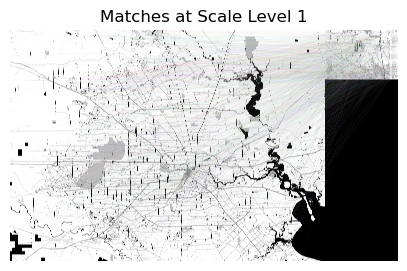

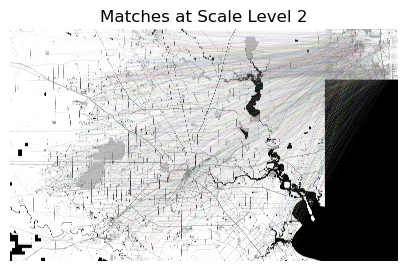

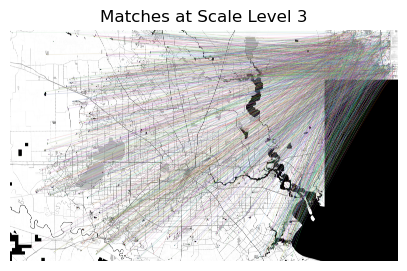

In [247]:
# Convert the match array to a single numpy array
#match_array = np.concatenate(match_array)

# Sort the matches by distance
# sorted_matches = match_array[match_array[:,2].argsort()]

# Plot the matches for each level of the pyramid
for i in range(num_scales):
    img1 = cv2.drawMatches(scaled_images1[i], keypoints1[i], scaled_images2[i], keypoints2[i], matches[i], None)
    plt.figure(figsize=(5,5))
    plt.imshow(img1)
    plt.axis('off')
    plt.title('Matches at Scale Level {}'.format(i+1))
    plt.show()

In [ ]:
import cv2
import numpy as np

# Load the images and detect keypoints
orb = cv2.ORB_create(nfeatures=1000)
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Create a Brute-Force Matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match the descriptors
matches = bf.match(des1, des2)

# Sort the matches by distance
matches = sorted(matches, key = lambda x:x.distance)

# Set the number of iterations and the threshold for inliers
iterations = 1
inlier_threshold = 10

# Set the minimum number of matches required for the transformation
if len(matches) < 3:
    raise ValueError('At least 3 matches are required for the transformation')
min_matches = 3

# Initialize variables to keep track of the best transformation
best_transform = None
best_inliers = []

# Create the scale-space pyramid for the first image
scale_factor = 2
scaled_images = [img1]
while scaled_images[-1].shape[0] > 100 and scaled_images[-1].shape[1] > 100:
    scaled = cv2.pyrDown(scaled_images[-1])
    print(scaled.shape)
    scaled_images.append(scaled)

# Iterate over each level in the pyramid
for i in range(len(scaled_images)-1, -1, -1):
    print(i)
    img1 = scaled_images[i]
    if i == len(scaled_images) - 1:
        kp1, desc1 = orb.detectAndCompute(img1, None)
        continue

    img2 = scaled_images[i+1]
    kp2, desc2 = orb.detectAndCompute(img2, None)
    
    # match descriptors between img1 and img2
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desc1, desc2)
    
    # filter matches using Lowe's ratio test
    good_matches = []
    for m,n in zip(matches[:-1:2], matches[1::2]):
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    if len(good_matches) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
        
        # Estimate the transform matrix using RANSAC algorithm
        transform, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold)
        
        # Use only inliers to estimate the transform matrix again
        good_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
        transform, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold)

        # Scale the transformation matrix for the next image size
        h1, w1 = img1.shape
        h2, w2 = img2.shape
        transform[0,2] *= w1/w2
        transform[1,2] *= h1/h2

        # Update the best transformation matrix
        if i == len(scaled_images) - 2:
            best_transform = transform
        else:
            best_transform = np.dot(transform, best_transform)

        # Update the keypoints and descriptors for the next iteration
        kp1, desc1 = kp2, desc2
    else:
        print("Not enough matches found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT))
        break


In [164]:
# Create ORB object
orb = cv2.ORB_create(nfeatures=1000)

# Detect and describe features for each level of the pyramid
keypoints = []
descriptors = []
for i in range(num_scales):
    kp, des = orb.detectAndCompute(scaled_images[i], None)
    keypoints.append(kp)
    descriptors.append(des)

# Match features between adjacent levels
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = []
for i in range(num_scales - 1):
    matches.append(bf.match(descriptors[i], descriptors[i+1]))

# Show the matches between the first two levels
img_matches = cv2.drawMatches(scaled_images[0], keypoints[0], scaled_images[1], keypoints[1], matches[0], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2.imshow('Matches', img_matches)

(8639, 11724)


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\pyramids.cpp:875: error: (-215:Assertion failed) ssize.width > 0 && ssize.height > 0 && std::abs(dsize.width*2 - ssize.width) <= 2 && std::abs(dsize.height*2 - ssize.height) <= 2 in function 'cv::pyrDown_'


In [ ]:
# Load the image
img = # cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)

# Set the number of scales
num_scales = 3

# Create a list to store the scaled images
scaled_images = []

# Add the original image to the list
scaled_images.append(img)

# Loop through the remaining scales and add them to the list
for i in range(1, num_scales):
    # Compute the scale factor for this level
    scale_factor = 2**i
    
    # Scale the image using Gaussian pyramid
    scaled = cv2.pyrDown(img, dstsize=(int(img.shape[1]/scale_factor), int(img.shape[0]/scale_factor)))
    
    # Add the scaled image to the list
    scaled_images.append(scaled)

# Display the images in the scale-space pyramid
for i in range(num_scales):
    cv2.imshow('Scale ' + str(i), scaled_images[i])

In [ ]:
# determine best transform
if len(good_matches) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
    
    # Estimate the transform matrix using RANSAC algorithm
    transform, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold)
    
    # Use only inliers to estimate the transform matrix again
    good_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
    transform, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold)

    # Apply the transformation to the corners of the source image to get the new bounding box
    h,w = img1.shape
    corners = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]], dtype=np.float32).reshape(-1,1,2)
    new_corners = cv2.perspectiveTransform(corners, transform)
    
    # Determine the max and min coordinates of the new bounding box
    x_min, y_min = np.int32(new_corners.min(axis=0).ravel())
    x_max, y_max = np.int32(new_corners.max(axis=0).ravel())
    h, w = img2.shape
    
    # Compute the offset for the transformation
    x_offset, y_offset = abs(x_min), abs(y_min)
    
    # Update the transformation matrix to include the offset
    offset_transform = np.array([[1, 0, x_offset], [0, 1, y_offset], [0, 0, 1]], dtype=np.float32)
    best_transform = np.dot(offset_transform, transform)
    
    # Apply the final transformation to the source image and merge with the target image
    result_img = cv2.warpPerspective(img1, best_transform, (x_max-x_min, y_max-y_min))
    result_img[y_offset:h+y_offset, x_offset:w+x_offset] = img2
    
    # Plot the matched keypoints between the two images
    draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, flags=2)
    result_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, **draw_params)
else:
    print("Not enough matches found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT))
    result_img = None


(9134, 2)
(12288, 2)


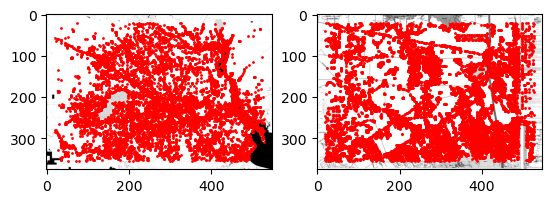

In [148]:
fig, ax = plt.subplots(1,2)

print(keypoints2.shape)
print(keypoints_base.shape)

ax[0].imshow(baseraster, cmap="Greys_r")
ax[0].scatter(keypoints2[:, 1], keypoints2[:, 0], 1, color="red")

ax[1].imshow(template_to_match, cmap="Greys_r")
ax[1].scatter(keypoints_base[:, 1], keypoints_base[:, 0], 1, color="red")

(3, 2)


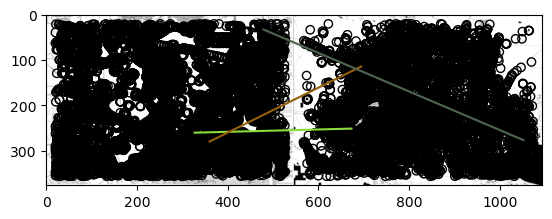

In [150]:
matches12 = match_descriptors(descriptors2,descriptors_base, max_ratio=0.8)
print(matches12.shape)
fig, ax = plt.subplots()
plot_matches(ax, template_to_match, baseraster, keypoints_base, keypoints2, matches12)

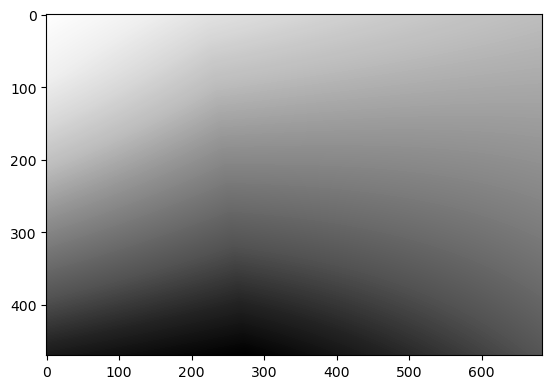

In [131]:
# `src` and `dst` are the matching feature coordinates in the source and destination images, respectively
src = keypoints2[matches12[:, 1], ::-1]
dst = keypoints_base[matches12[:, 0], ::-1]

# Estimate the transformation between the two images using RANSAC
tform = estimate_transform('similarity', src, dst)
warped = warp(tomatch_resize.astype(np.uint8), tform, output_shape=tomatch_resize.shape, mode='wrap')
plt.imshow(warped,cmap="Greys_r")

In [132]:
tform.params

array([[-2.31787141e-04, -2.07862540e-03,  7.01776620e+01],
       [ 2.07862540e-03, -2.31787141e-04,  4.75381738e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [46]:
# Open the geotiff file with rasterio
with rio.open(r'D:\FloodChange\BaseRaster\BaseTest.tif') as src:
    # Read the georeferencing transform
    geo_transform = src.transform
    
geo_matrix = np.array(geo_transform).reshape((3,3))
geo_affine = AffineTransform(matrix=geo_matrix)

In [72]:
origin_y = -1000
origin_x = 9000

offset = np.array([
    [1, 0, origin_x],
    [0, 1, origin_y],
    [0, 0,        1]
         ])

rescale = np.array([
    [0.125, 0    , 0],
    [    0, 0.125, 0],
    [    0, 0    , 1]
])

In [80]:
image_to_frame = tform.params
print(image_to_frame)
R_frame = image_to_frame @ rescale
print(R_frame)

[[-1.34233615e+00  9.74209158e-01  2.05825372e+03]
 [-9.74209158e-01 -1.34233615e+00  1.98014745e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-1.67792019e-01  1.21776145e-01  2.05825372e+03]
 [-1.21776145e-01 -1.67792019e-01  1.98014745e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [76]:
# TRANSFORMATIONS
image_to_frame = tform
frame_to_map = offset
CRS_to_map = geo_affine
print(image_to_frame)
print(frame_to_map)
print(CRS_to_map)

map_to_frame = frame_to_map
frame_to_image = image_to_frame.params
combined_matrix = CRS_to_map @ map_to_frame @ frame_to_image

print("COMBINED")
print(combined_matrix)

<SimilarityTransform(matrix=
    [[-1.34233615e+00,  9.74209158e-01,  2.05825372e+03],
     [-9.74209158e-01, -1.34233615e+00,  1.98014745e+03],
     [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])>
[[    1     0  9000]
 [    0     1 -1000]
 [    0     0     1]]
<AffineTransform(matrix=
    [[ 4.99993598e+00,  0.00000000e+00, -1.06823104e+07],
     [ 0.00000000e+00, -5.00007559e+00,  3.52549126e+06],
     [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])>
COMBINED
[[-8.38949353e-01  6.08872928e-01 -1.06360246e+07]
 [ 6.08889929e-01  8.38972778e-01  3.52925372e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [77]:
transform = Affine(*combined_matrix.flatten()[:6])
output_image=tomatch_map
print(output_image.shape)

with rio.open('test6.tif', 'w', 
                   driver='GTiff', 
                   height=output_image.shape[0], 
                   width=output_image.shape[1],
                   count=1,
                   dtype=output_image.dtype, 
                   crs=CRS.from_epsg(3857), 
                   transform=transform) as dst:
    # Write the output image to the file
    dst.write(output_image, indexes=1)

(3766, 5474)


In [ ]:
with rasterio.open(r'output10.tif') as src:
    # Read the georeferencing transform
    print(src.transform)
    
with rasterio.open(r'output11.tif') as src:
    # Read the georeferencing transform
    print(src.transform)

In [93]:
template_to_match = resize(tomatch_map, (tomatch_map.shape[0] // 39.37, tomatch_map.shape[1] // 39.37))
baseraster = resize(base_map, (tomatch_map.shape[0] // 6, tomatch_map.shape[1] // 6))

In [96]:
template_to_match.shape

(95, 139)

In [119]:
descriptor_extractor = ORB(n_keypoints=200)
descriptor_extractor.detect_and_extract(template_test)
keypoints_base = descriptor_extractor.keypoints
descriptors_base = descriptor_extractor.descriptors

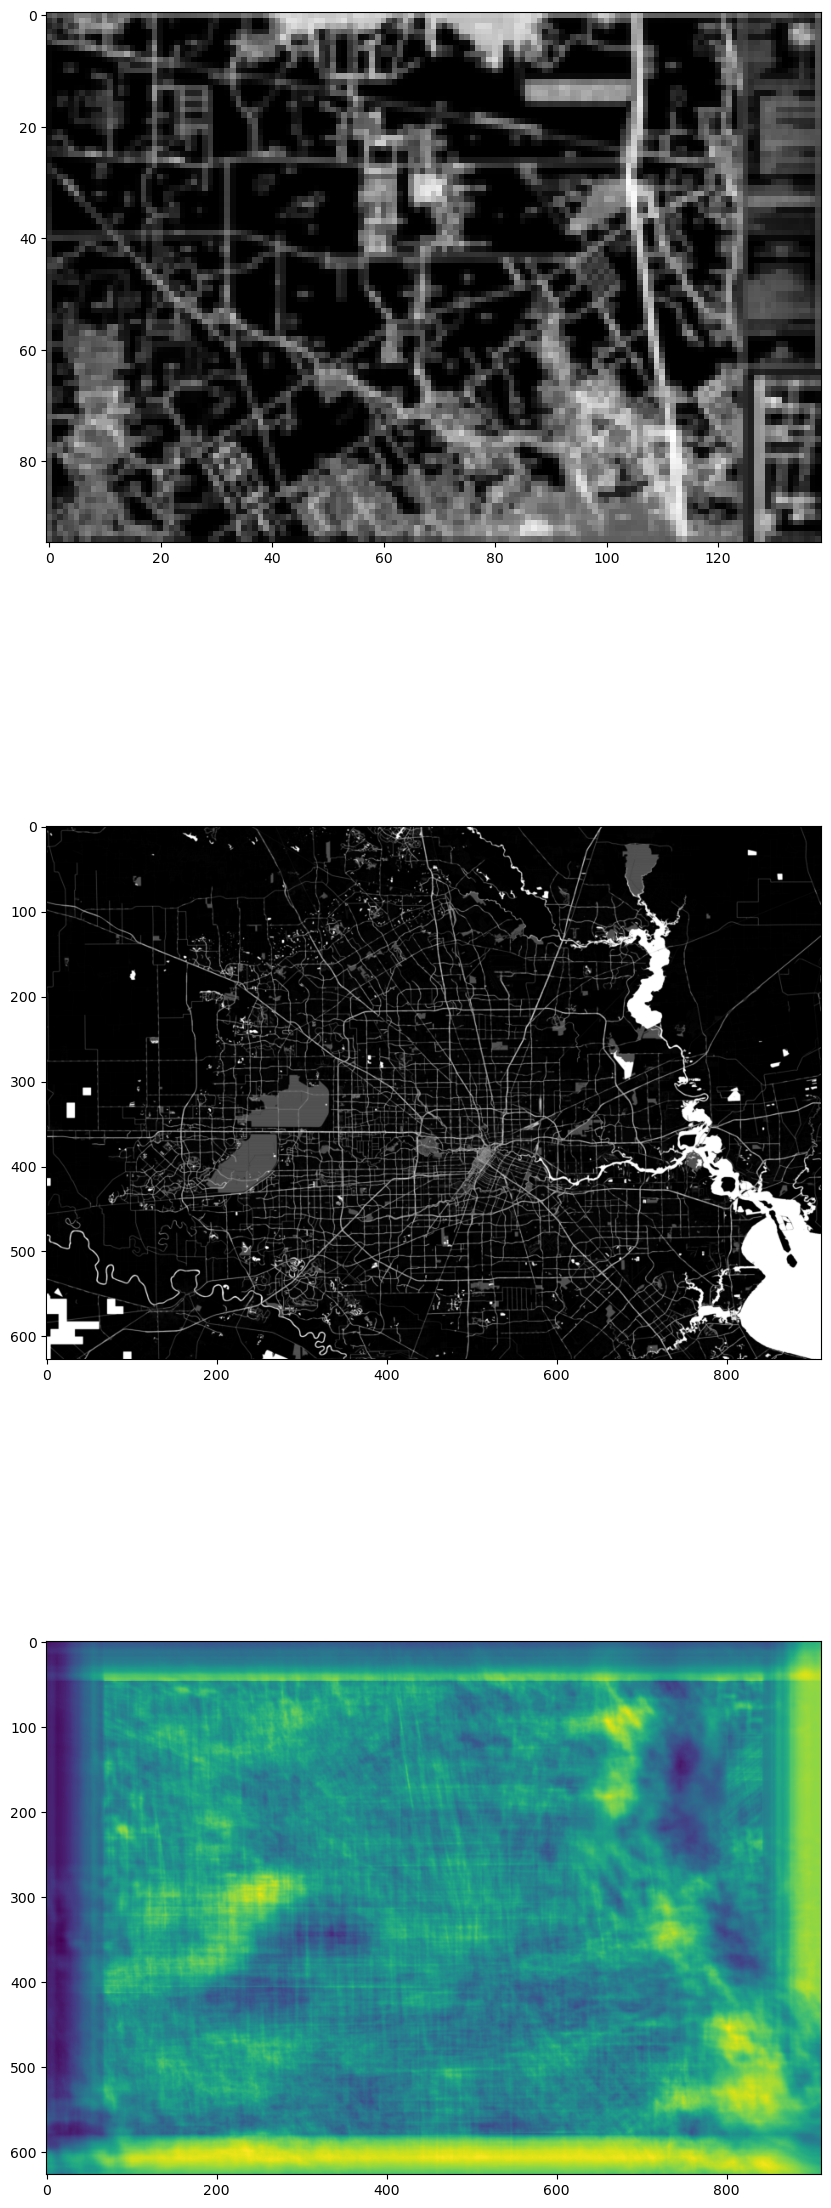

In [118]:
fig, axs = plt.subplots(3, 1, figsize=(10, 30))

template_test = template_to_match * 255
baseraster_test = baseraster *255
res = match_template(baseraster_test,template_test,"TM_CCORR_NORMED ")

axs[0].imshow(template_test, cmap="Greys")
axs[1].imshow(baseraster_test, cmap="Greys")
axs[2].imshow(res)